# Jupyter Notebook for Testing/Running Subsets of the total Assigment Code

In [2]:
from __future__ import print_function, division, absolute_import
import marvin
from marvin.tools.maps import Maps
from marvin.tools.image import Image
from marvin import config
from marvin.tools.cube import Cube
from marvin.tools.query import Query
from marvin.utils.datamodel.query.MPL import DR15
from marvin.utils.general.general import getSpaxel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
plt.ion()
#Defining class to do linear regession using torch NN 
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

plt.ion()

#set config attributes and turn on global downloads of Marvin data
config.setRelease('DR15')
config.mode = 'local'
config.download = True


[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


# Importing Relevant Packages/Classes etc 

In [3]:
#Importing All MaNGA Data from DPRall Schema
data=pd.read_csv('CompleteTable.csv')


galaxy_list=np.loadtxt('Query Results',dtype=str)
#Pulling mass and SFR for galaxies from Cas Jobs table
galaxy_index=np.zeros(len(galaxy_list))

for i in range (len(galaxy_list)):
    galaxy_index[i]=np.where(data.loc[:,'mangaid']==galaxy_list[i])[0][0]

galaxy_index=np.array(galaxy_index,dtype=int)



galaxies=data.iloc[galaxy_index]

mass=galaxies.loc[:,'nsa_sersic_mass']
log_mass=np.log10(mass)

SFR=galaxies.loc[:,'sfr_tot']
log_SFR=np.log10(SFR)

ha_flux=galaxies.loc[:,'emline_gflux_tot_ha_6564']

n=galaxies.loc[:,'nsa_sersic_n']



# 1D Regression with CUDA Enabled 

In [3]:
#Prepare Data

sSFR=SFR/mass #Calculating sSFR

log_sSFR=np.log10(sSFR)

log_sSFR=np.array(log_sSFR,dtype=np.float32).reshape(-1,1) #Changing data from pd dataframe to arrays to make it easier to feed to Torch 

n=np.array(n,dtype=np.float32).reshape(-1,1)
n=np.log10(n)


#Model 
inputDim=1
outputDim=1 
learningRate=0.1

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array=np.zeros(epochs)
loss_array=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(log_sSFR).cuda())
        labels = Variable(torch.from_numpy(n).cuda())
    else:
        inputs = Variable(torch.from_numpy(log_sSFR))
        labels = Variable(torch.from_numpy(n))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters, (backward pass)
    loss.backward()

    # update parameters
    optimizer.step()

    epoch_array[epoch]=epoch 
    loss_array[epoch]=loss.item()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(log_sSFR).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(log_sSFR))).data.numpy()
    print(predicted)



plt.clf()
plt.plot(log_sSFR, n, 'go', label='True data', alpha=0.5)
plt.plot(log_sSFR, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()


48, loss 0.0541398860514164
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1749, loss 0.05413820967078209
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1750, loss 0.05413654446601868
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1751, loss 0.05413488298654556
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1752, loss 0.05413324013352394
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1753, loss 0.05413158982992172
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1754, loss 0.05412996560335159
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1755, loss 0.05412835255265236
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1756, loss 0.05412673577666283
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1757, loss 0.05412512645125389
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1758, loss 0.05412353202700615
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1759, loss 0.0541219525039196
tensor(0.0541, grad_fn=<MseLossBackward>)
epoch 1760, loss 0.054120369255542755
tensor(0.0541, grad_fn=<

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
model.linear.bias

Parameter containing:
tensor([-1.9907], device='cuda:0', requires_grad=True)

# 2D Linear Regression using self built model and no CUDA

[[ 0.00071586 -0.00013521]], b = 0.4022584855556488
t = 1797, loss = 0.04663068801164627, A = [[ 0.00071213 -0.00013451]], b = 0.40229764580726624
t = 1798, loss = 0.04663068801164627, A = [[ 0.00070841 -0.0001338 ]], b = 0.40233662724494934
t = 1799, loss = 0.046630680561065674, A = [[ 0.00070472 -0.0001331 ]], b = 0.4023754298686981
t = 1800, loss = 0.046630680561065674, A = [[ 0.00070104 -0.00013241]], b = 0.4024140536785126
t = 1801, loss = 0.046630680561065674, A = [[ 0.00069738 -0.00013172]], b = 0.4024524986743927
t = 1802, loss = 0.046630680561065674, A = [[ 0.00069373 -0.00013103]], b = 0.4024907648563385
t = 1803, loss = 0.046630676835775375, A = [[ 0.00069011 -0.00013034]], b = 0.40252885222435
t = 1804, loss = 0.046630680561065674, A = [[ 0.0006865  -0.00012967]], b = 0.4025667607784271
t = 1805, loss = 0.046630676835775375, A = [[ 0.00068291 -0.00012899]], b = 0.40260449051856995
t = 1806, loss = 0.046630676835775375, A = [[ 0.00067933 -0.00012831]], b = 0.4026420712471008

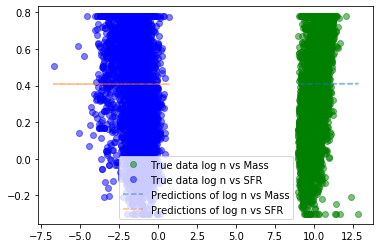

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
#Two input and one output linear regression 

log_mass_sfr=pd.concat([log_mass,log_SFR],axis=1) #Combining both input variables into one df

log_mass_sfr=np.array(log_mass_sfr,dtype=np.float32).transpose() #Formatting properly for pytorch 

#Defining the model 
# First we define the trainable parameters A and b 
A = torch.randn((1, 2), requires_grad=True)
b = torch.randn(1, requires_grad=True)

def model(x_input):
    return A.mm(x_input) + b

#Chosing a loss function
loss= torch.nn.SmoothL1Loss()

### Training the model ###

# Setup the optimizer object, so it optimizes a and b.
optimizer = torch.optim.Adam([A, b], lr=0.1)

epoch_array2=np.zeros(2000)
loss_array2=np.zeros(2000)
# Main optimization loop
for t in range(2000): #t is epochs

    inputs = Variable(torch.from_numpy(log_mass_sfr))
    labels = Variable(torch.from_numpy(n))

    # Set the gradients to 0.
    optimizer.zero_grad()
    # Compute the current predicted y's from x_dataset
    y_predicted = model(inputs)
    # See how far off the prediction is
    current_loss = loss(y_predicted, labels)
    # Compute the gradient of the loss with respect to A and b.
    current_loss.backward()
    # Update A and b accordingly.
    optimizer.step()

    epoch_array2[t]=t 
    loss_array2[t]=current_loss.item()
    print(f"t = {t}, loss = {current_loss}, A = {A.detach().numpy()}, b = {b.item()}")

plt.plot(log_mass_sfr[0,:], n, 'go', label='True data log n vs Mass', alpha=0.5)
plt.plot(log_mass_sfr[1,:], n, 'bo', label='True data log n vs SFR', alpha=0.5)
plt.plot(log_mass_sfr[0,:], A.detach().numpy()[0][0]*log_mass_sfr[0,:]+b.item(), '--', label='Predictions of log n vs Mass', alpha=0.5)
plt.plot(log_mass_sfr[1,:], A.detach().numpy()[0][1]*log_mass_sfr[1,:]+b.item(), '--', label='Predictions of log n vs SFR', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

In [7]:
a = np.array([[1,2,3], [4,5,6]])
b=np.reshape(a,(1,-1))
c=a.flatten()
print(a)
print(b)
print(c)
np.shape(n)



[[1 2 3]
 [4 5 6]]
[[1 2 3 4 5 6]]
[1 2 3 4 5 6]


(3638, 1)

# 2D Linear Regression using torch.nn.Linear and CUDA enabled 

In [8]:
#Model 
inputDim=2
outputDim=1 
learningRate=0.1

log_mass_sfr=pd.concat([log_mass,log_SFR],axis=1) #Combining both input variables into one df

log_mass_sfr=np.array(log_mass_sfr,dtype=np.float32) #Formatting properly for pytorch 


model = torch.nn.Linear(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array3=np.zeros(epochs)
loss_array3=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(log_mass_sfr).cuda())
        labels = Variable(torch.from_numpy(n).cuda())
    else:
        inputs = Variable(torch.from_numpy(log_mass_sfr))
        labels = Variable(torch.from_numpy(n))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters, (backward pass)
    loss.backward()

    # update parameters
    optimizer.step()

    epoch_array3[epoch]=epoch 
    loss_array3[epoch]=loss.item()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(log_mass_sfr).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(log_mass_sfr))).data.numpy()
    print(predicted)



plt.clf()
plt.plot(log_mass_sfr[:,1], n, 'go', label='True data (n vs Mass)', alpha=0.5)
plt.plot(log_mass_sfr[:,0], n, 'go', label='True data (n vs SFR)', alpha=0.5)
plt.plot(log_mass_sfr[:,1], predicted, '--', label='Predictions (n vs Mass)', alpha=0.5)
plt.plot(log_mass_sfr[:,0], predicted, '--', label='Predictions (n vs SFR)', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

plt.title('Loss vs Epoch for 2D Linear Regression (CUDA)')
plt.plot(epoch_array3,loss_array3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.figure()


tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1793, loss 0.04620761424303055
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1794, loss 0.04620426520705223
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1795, loss 0.04620092362165451
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1796, loss 0.04619760066270828
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1797, loss 0.04619428515434265
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1798, loss 0.04619097337126732
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1799, loss 0.04618768393993378
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1800, loss 0.046184394508600235
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1801, loss 0.046181123703718185
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1802, loss 0.04617786034941673
tensor(0.0462, device='cuda:0', grad_

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

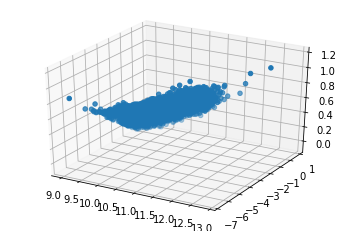

In [9]:
from mpl_toolkits.mplot3d import Axes3D
ax= plt.axes(projection='3d')
ax.scatter3D(log_mass_sfr[:,0].flatten(),log_mass_sfr[:,1].flatten(),predicted.flatten(),cmap='magma')



# Doing Linear Regression Using Data Loaders and a 60-20-20 Train-Test-Validate Split

In [4]:
#Working with making a neural net with a hidden layer

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        x1 = self.linear(x)
        out = self.linear(x1)
        return out


#Importing clean data 

sSFR=SFR/mass #Calculating sSFR
log_sSFR=np.log10(sSFR)
log_sSFR=np.array(log_sSFR,dtype=np.float32)

n=galaxies.loc[:,'nsa_sersic_n']
n=np.log10(n)
n=np.array(n,dtype=np.float32)

#Creating paritions in the data to define the 60-20-20 split 
train_sSFR=torch.from_numpy(log_sSFR[0:2183].reshape(-1,1)).to('cuda:0')
test_sSFR=torch.from_numpy(log_sSFR[2183:2910].reshape(-1,1)).to('cuda:0')
validate_sSFR=torch.from_numpy(log_sSFR[2910:3638].reshape(-1,1)).to('cuda:0')

train_n=torch.from_numpy(n[0:2183].reshape(-1,1)).to('cuda:0')
test_n=torch.from_numpy(n[2183:2910].reshape(-1,1)).to('cuda:0')
validate_n=torch.from_numpy(n[2910:3638].reshape(-1,1)).to('cuda:0')

#Creating Tensor Datasets 
train_dataset= TensorDataset(train_sSFR,train_n)
test_dataset= TensorDataset(test_sSFR,test_n)
validate_dataset=TensorDataset(validate_sSFR,validate_n)

#Putting these partitions into a pytorch DataLoader 
train_dataloader= DataLoader(train_dataset,batch_size=len(train_sSFR),shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=len(test_sSFR), shuffle=True)
validate_dataloader= DataLoader(validate_dataset, batch_size=len(validate_sSFR), shuffle=True)




RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

AttributeError: 'DataLoader' object has no attribute 'cuda'

In [22]:
#Model 
inputDim=1
outputDim=1 
learningRate=0.1

model = torch.nn.Linear(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array4=np.zeros(epochs)
loss_array4=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    for xb,yb in train_dataloader:
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(xb)

        # get loss for the predicted output
        loss = criterion(outputs, yb)
        print(loss)
        # get gradients w.r.t to parameters, (backward pass)
        loss.backward()

        # update parameters
        optimizer.step()

        epoch_array4[epoch]=epoch 
        loss_array4[epoch]=loss.item()

        print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = model(train_sSFR)
    print(predicted)
plt.plot(train_sSFR.cpu().numpy(), train_n.cpu().numpy(), 'go', label='Training data', alpha=0.5)
plt.plot(train_sSFR.cpu().numpy(), predicted.cpu().numpy(), '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

kward>)
epoch 1793, loss 0.054599273949861526
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1794, loss 0.05459924042224884
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1795, loss 0.054599206894636154
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1796, loss 0.05459917336702347
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1797, loss 0.05459914356470108
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1798, loss 0.054599106311798096
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1799, loss 0.054599080234766006
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1800, loss 0.05459904670715332
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1801, loss 0.05459901690483093
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1802, loss 0.054598983377218246
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1803, loss 0.05459895

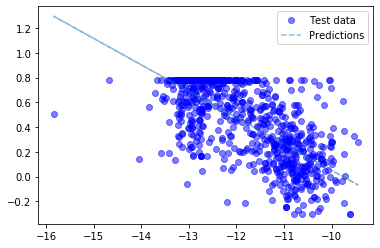

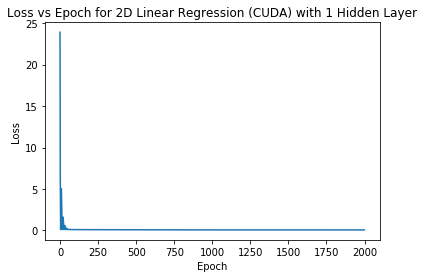

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [36]:
#Testing the model with test datamodel 

predicted_test=model(test_sSFR)

plt.plot(test_sSFR.cpu().numpy(), test_n.cpu().numpy(), 'bo', label='Test data', alpha=0.5)
plt.plot(test_sSFR.cpu().numpy(), predicted_test.cpu().detach().numpy(), '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

predicted_validate=model(validate_sSFR)

plt.plot(validate_sSFR.cpu().numpy(), validate_n.cpu().numpy(), 'ro', label='Validate data', alpha=0.5)
plt.plot(validate_sSFR.cpu().numpy(), predicted_validate.cpu().detach().numpy(), '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

plt.title('Loss vs Epoch for 1D Linear Regression (CUDA) with 1 Hidden Layer')
plt.plot(epoch_array4,loss_array4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.figure()
